In [1]:
from sms.data.utils.pyramid_embedding_dataloader2 import PyramidEmbeddingDataloader
from sms.data.utils.dino_dataloader2 import DinoDataloader
from sms.encoders.image_encoder import BaseImageEncoderConfig
from sms.encoders.openclip_encoder import OpenCLIPNetworkConfig
from torch.utils import data
import torch.nn as nn
from typing import Dict, ForwardRef, Generic, List, Literal, Optional, Tuple, Type, Union, cast, get_args, get_origin
from torchvision import transforms
import matplotlib.pyplot as plt
from nerfstudio.utils.colormaps import apply_colormap
import torch
from matplotlib.patches import Circle

device = 'cuda:0'
"""The device to run on"""
patch_tile_size_range: Tuple[int, int] = (0.08, 0.5)
"""The range of tile sizes to sample from for patch-based training"""
patch_tile_size_res: int = 7
"""The number of tile sizes to sample from for patch-based training"""
patch_stride_scaler: float = 0.5
"""The stride scaler for patch-based training"""
network: BaseImageEncoderConfig = OpenCLIPNetworkConfig(device=device)
"""specifies the vision-language network config"""
clip_downscale_factor: int = 1
"""The downscale factor for the clip pyramid"""

dino_dataloader = DinoDataloader(
            # image_list=images,
            device=device,
            cfg={"image_shape": [480,640]},
            # cache_path=dino_cache_path,
        )
torch.cuda.empty_cache()

clip_interpolator = PyramidEmbeddingDataloader(
    device=device,
    cfg={
        "tile_size_range": list(patch_tile_size_range),
        "tile_size_res": patch_tile_size_res,
        "stride_scaler": patch_stride_scaler,
        "image_shape": [480,640],
    },
    model=network.setup()
)
image_encoder = clip_interpolator.model

transform = transforms.Compose([
    transforms.ToTensor()
])

In [2]:
import torchvision
import numpy as np
from matplotlib import pyplot as plt
def tt2clipinterp(tt_frame, clip_downscale_factor=1):
    to_pil = torchvision.transforms.ToPILImage()
    image = transform(to_pil(tt_frame.permute(2, 0, 1).to(torch.uint8)))
    clip_interpolator.generate_clip_interp(image)
    H, W = image.shape[1:]
    # scale = torch.tensor(0.1).to(device)
    scaled_height = H//clip_downscale_factor
    scaled_width = W//clip_downscale_factor

    x = torch.arange(0, scaled_width*clip_downscale_factor, clip_downscale_factor).view(1, scaled_width, 1).expand(scaled_height, scaled_width, 1).to(device)
    y = torch.arange(0, scaled_height*clip_downscale_factor, clip_downscale_factor).view(scaled_height, 1, 1).expand(scaled_height, scaled_width, 1).to(device)
    image_idx_tensor = torch.zeros(scaled_height, scaled_width, 1).to(device)
    positions = torch.cat((image_idx_tensor, y, x), dim=-1).view(-1, 3).to(int)
    with torch.no_grad():
        # data["clip"], data["clip_scale"] = clip_interpolator(positions, scale)[0], clip_interpolator(positions, scale)[1]
        data = clip_interpolator(positions)[0].view(H, W, -1)
    return data

def tt2dino(tt_frame, clip_downscale_factor=1):
    im = tt_frame.permute(2, 0, 1).to(torch.float32)
    dino_dataloader.generate_dino_embed(im)
    H, W = im.shape[1:]
    # scale = torch.tensor(0.1).to(device)
    scaled_height = H//clip_downscale_factor
    scaled_width = W//clip_downscale_factor

    x = torch.arange(0, scaled_width*clip_downscale_factor, clip_downscale_factor).view(1, scaled_width, 1).expand(scaled_height, scaled_width, 1).to(device)
    y = torch.arange(0, scaled_height*clip_downscale_factor, clip_downscale_factor).view(scaled_height, 1, 1).expand(scaled_height, scaled_width, 1).to(device)
    image_idx_tensor = torch.zeros(scaled_height, scaled_width, 1).to(device)
    positions = torch.cat((image_idx_tensor, y, x), dim=-1).view(-1, 3).to(int)
    # print(positions.device)
    with torch.no_grad():
        data = dino_dataloader(positions.cpu()).view(H, W, -1)
    return data

In [3]:
def plot_clip_relevancy(img, query):
    '''
    img: torch.Tensor
    query: str
    '''
    # Show image and heatmap side by side
    positive = []
    positive.append(query)
    clip_frame = tt2clipinterp(img)
    
    H = clip_frame.shape[0]
    W = clip_frame.shape[1]
    image_encoder.set_positives(positive)
    probs = image_encoder.get_relevancy(clip_frame.view(-1, image_encoder.embedding_dim), 0)
    # gaussian_blur = torchvision.transforms.GaussianBlur(kernel_size=3, sigma=(3.0))

    # probs = gaussian_blur(probs.reshape(-1, H, W)).reshape(H, W, -1)
    
    h_axis_clip_signal = torch.sum(probs.reshape([H,W,2]), dim=0)
    v_axis_clip_signal = torch.sum(probs.reshape([H,W,2]), dim=1)
    
    color = apply_colormap(probs[..., 0:1])
    color = color.reshape([H,W,3])
    fig, ax = plt.subplots(2, 2, height_ratios=[3, 1])
    plt.tight_layout()
    circ1 = Circle((h_axis_clip_signal[:, 0].argmax().item(), v_axis_clip_signal[:, 0].argmax().item()), 4, facecolor='r', edgecolor='black')
    circ2 = Circle((h_axis_clip_signal[:, 0].argmax().item(), v_axis_clip_signal[:, 0].argmax().item()), 4, facecolor='r', edgecolor='black')
    ax[0][0].imshow(img.cpu().numpy())
    ax[0][0].add_patch(circ1)
    fig.set_figheight(7.5)
    fig.set_figwidth(13)
    ax[0][1].imshow(color.cpu().numpy())
    ax[0][1].add_patch(circ2)
    ax[1][0].axis('off')
    ax[1][0].text(0, 0.8, 'Max Relevancy Score (X-Axis): ', fontsize = 12)
    ax[1][0].text(0.55, 0.8, str(h_axis_clip_signal[:, 0].max().item()), fontsize = 12)
    ax[1][0].text(0, 0.6, 'Max Relevancy Score (Overall): ', fontsize = 12)
    ax[1][0].text(0.55, 0.6, str(probs.max().item()), fontsize = 12)
    ax[1][0].text(0, 0.4, "Argmax Relevancy (X-Axis): ", fontsize = 12)
    ax[1][0].text(0.55, 0.4, str(h_axis_clip_signal[:, 0].argmax().item()), fontsize = 12)
    ax[1][1].plot(h_axis_clip_signal[:,0].cpu().numpy())
    ax[1][1].set_xlim([0, W])
    # ax[1][1].set_ylim(ymin=0)
    ax[1][1].grid()
    ax[1][1].set_title("Horizontal-Axis Relevancy")

    fig.suptitle("CLIP Query: \"" + positive[0] + "\"")

In [4]:
def plot_dino_relevancy(img, queryimg, mask = None):
    '''
    img: torch.Tensor
    queryimg: torch.Tensor
    '''
    # Show image and heatmap side by side

    cos_sim = nn.CosineSimilarity(dim=1, eps=1e-6)

    dino_frame_real = tt2dino(img)
    dino_frame_query = tt2dino(queryimg)
    H = dino_frame_real.shape[0]
    W = dino_frame_real.shape[1]
    if mask is not None:
        dino_frame_query = dino_frame_query.view(H*W,-1)[mask]
        # queryimg.view(H*W,-1)[mask] = 0
        # plt.imshow(queryimg.cpu().numpy())
    print(dino_frame_query.shape)
    query_mean_embedding = dino_frame_query.mean(dim=(0,1)).unsqueeze(0)

    print(query_mean_embedding.shape)

    probs = cos_sim(dino_frame_real.view(-1, dino_frame_real.shape[-1]), query_mean_embedding) #.view(H, W)
    # print(probs.min())
    print(probs.shape)
    # print(probs.mean())

    # print((probs == probs.max()).nonzero())
    print(probs.argmax())
    ch, cw = divmod(probs.argmax().item(), W)

    # ch, cw = (probs == probs.reshape([H,W]).max()).nonzero()
    # print(ch, cw)
    h_axis_dino_signal = torch.sum(probs.reshape([H,W,1]), dim=0)
    v_axis_dino_signal = torch.sum(probs.reshape([H,W,1]), dim=1)

    # probs normalized
    probs_norm = (probs - probs.min())/(probs.max() - probs.min())

    color = apply_colormap(probs_norm.reshape([H,W,1]))
    color = color.reshape([H,W,3])
    fig, ax = plt.subplots(2, 2, height_ratios=[3, 1])
    plt.tight_layout()
    circ1 = Circle((ch, cw), 4, facecolor='r', edgecolor='black')
    circ2 = Circle((ch, cw), 4, facecolor='r', edgecolor='black')

    ax[0][0].imshow(img.cpu().numpy())
    ax[0][0].add_patch(circ1)
    fig.set_figheight(7.5)
    fig.set_figwidth(13)
    
    ax[0][1].imshow(color.cpu().numpy())

    ax[0][1].add_patch(circ2)
    ax[1][0].axis('off')
    ax[1][0].text(0, 0.8, 'Max Relevancy Score (X-Axis): ', fontsize = 12)
    ax[1][0].text(0.55, 0.8, str(h_axis_dino_signal.max().item()), fontsize = 12)
    ax[1][0].text(0, 0.6, 'Max Relevancy Score (Overall): ', fontsize = 12)
    ax[1][0].text(0.55, 0.6, str(probs.max().max().item()), fontsize = 12)
    ax[1][0].text(0, 0.4, "Argmax Relevancy (X-Axis): ", fontsize = 12)
    ax[1][0].text(0.55, 0.4, str(h_axis_dino_signal.argmax().item()), fontsize = 12)
    ax[1][1].plot(h_axis_dino_signal.cpu().numpy())
    ax[1][1].set_xlim([0, W])
    # ax[1][1].set_ylim(ymin=0)
    ax[1][1].grid()
    ax[1][1].set_title("Horizontal-Axis Relevancy")

    fig.suptitle("DINO Relevancy")

In [5]:
from PIL import Image
im_frame1 = Image.open('test_imgs/BWWK/IMG_6409.jpeg')
im_frame1 = im_frame1.resize((640, 480))
np_frame1 = np.array(im_frame1)

Scales: 100%|██████████| 7/7 [00:00<00:00, 8456.26it/s]


here 38 32 19
here 72 36 36
here 105 52 52
here 139 69 69
here 172 86 86
here 206 103 103
here 240 120 120


Scales:   0%|          | 0/7 [00:00<?, ?it/s]/home/yujustin/.local/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
Scales: 100%|██████████| 7/7 [00:00<00:00, 13.30it/s]


PyramidEmbeddingProcess took 0.5271596908569336 seconds


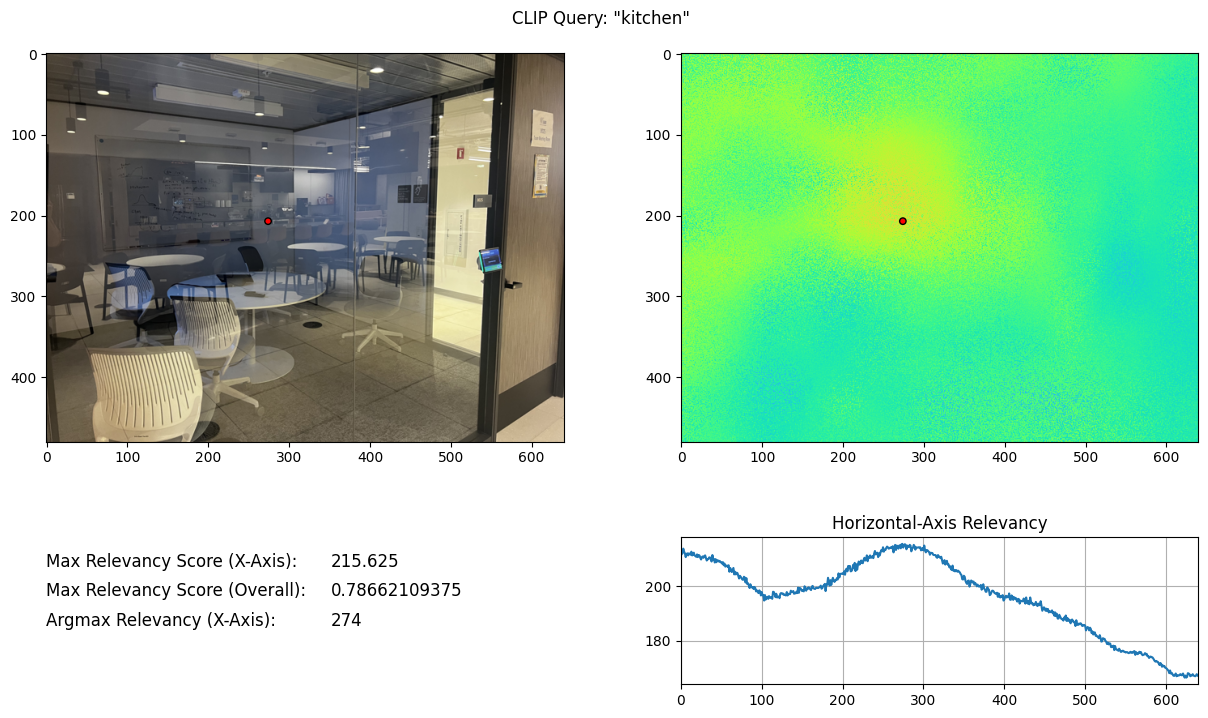

In [6]:
plot_clip_relevancy(torch.from_numpy(np_frame1).cuda(), "kitchen")

Scales: 100%|██████████| 7/7 [00:00<00:00, 10141.67it/s]


here 38 32 19
here 72 36 36
here 105 52 52
here 139 69 69
here 172 86 86
here 206 103 103
here 240 120 120


Scales: 100%|██████████| 7/7 [00:00<00:00, 15.56it/s]


PyramidEmbeddingProcess took 0.45066165924072266 seconds


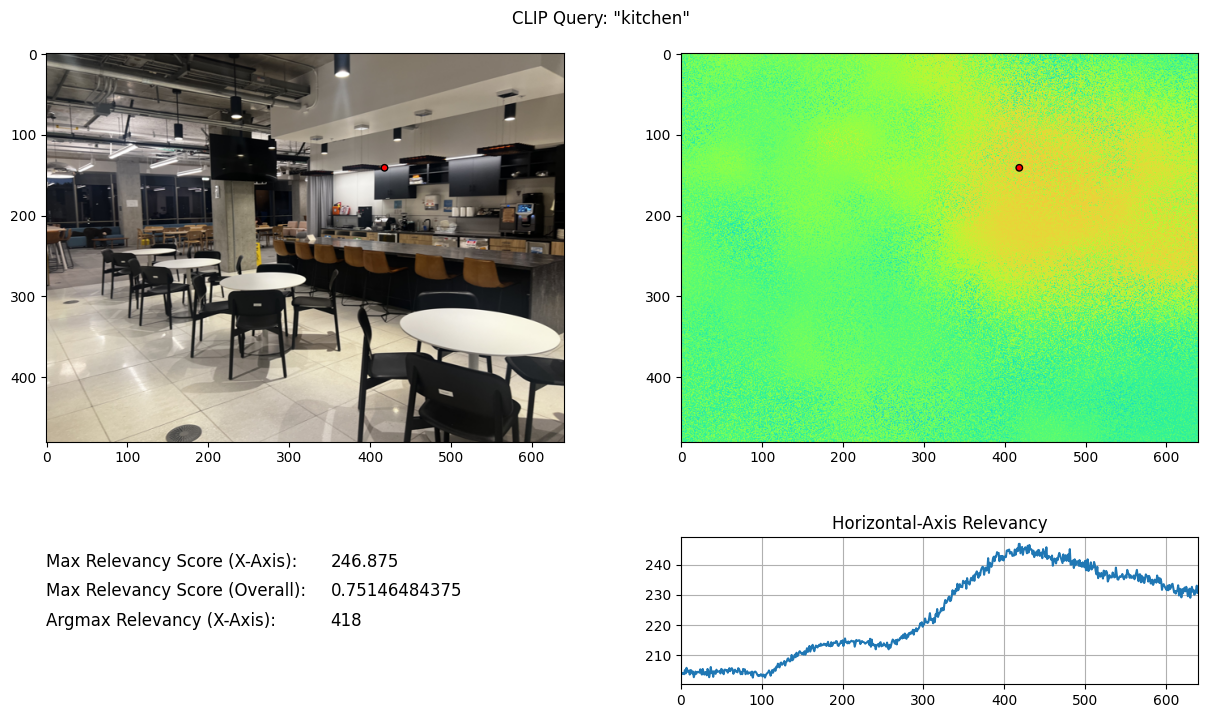

In [7]:
im_frame2 = Image.open('test_imgs/BWWK/IMG_6416.jpeg')
im_frame2 = im_frame2.resize((640, 480))
np_frame2 = np.array(im_frame2)
plot_clip_relevancy(torch.from_numpy(np_frame2).cuda(), "kitchen")

Scales: 100%|██████████| 7/7 [00:00<00:00, 9619.96it/s]


here 38 32 19
here 72 36 36
here 105 52 52
here 139 69 69
here 172 86 86
here 206 103 103
here 240 120 120


Scales: 100%|██████████| 7/7 [00:00<00:00, 15.58it/s]


PyramidEmbeddingProcess took 0.4500093460083008 seconds


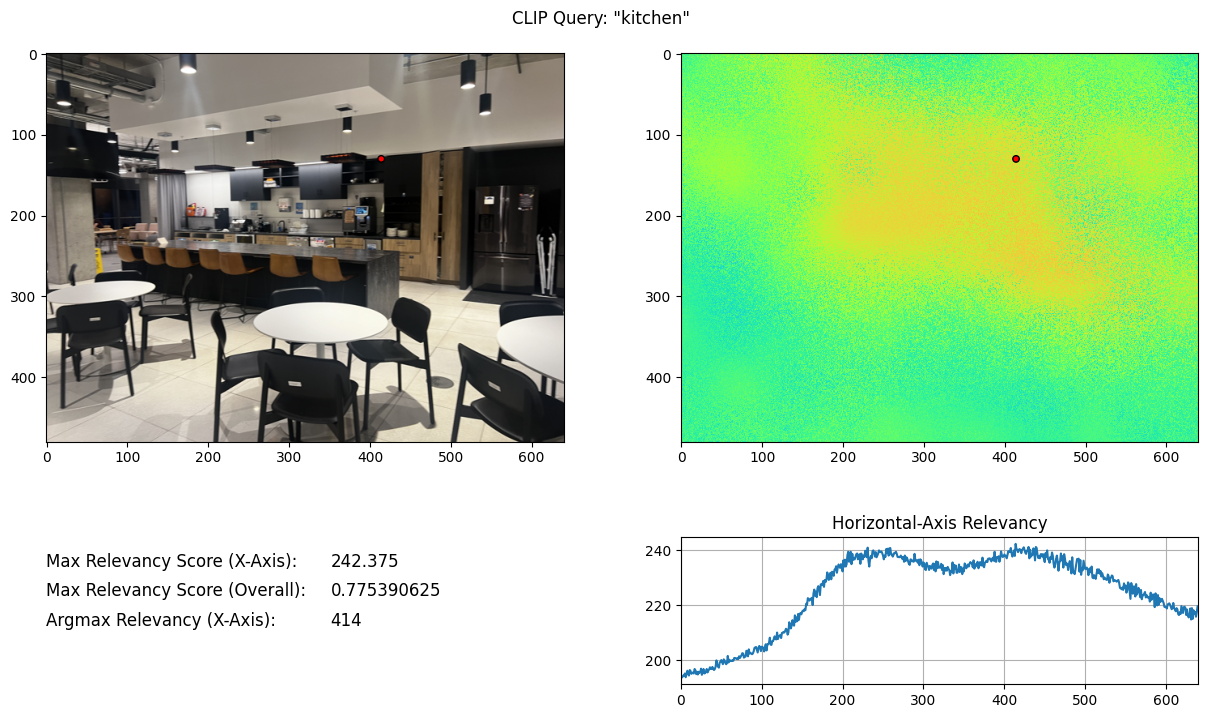

In [8]:
im_frame2 = Image.open('test_imgs/BWWK/IMG_6418.jpeg')
im_frame2 = im_frame2.resize((640, 480))
np_frame2 = np.array(im_frame2)
plot_clip_relevancy(torch.from_numpy(np_frame2).cuda(), "kitchen")

Scales: 100%|██████████| 7/7 [00:00<00:00, 10653.17it/s]


here 38 32 19
here 72 36 36
here 105 52 52
here 139 69 69
here 172 86 86
here 206 103 103
here 240 120 120


Scales: 100%|██████████| 7/7 [00:00<00:00, 15.66it/s]


PyramidEmbeddingProcess took 0.44786739349365234 seconds


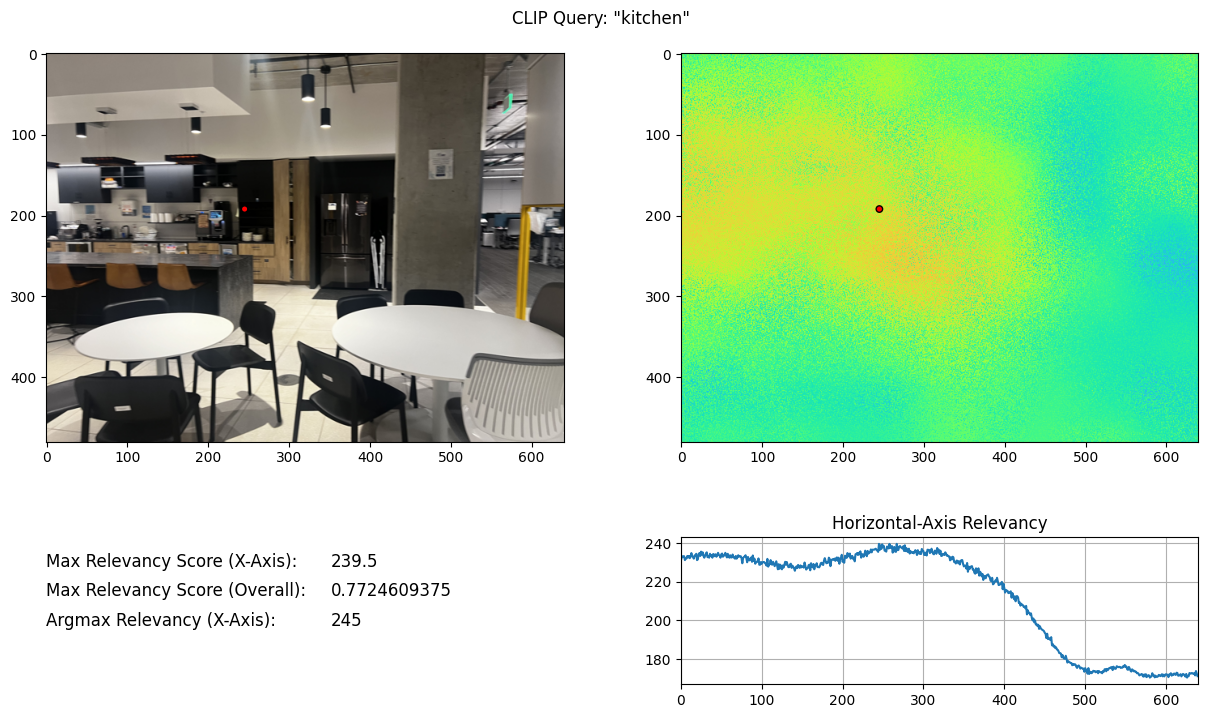

In [9]:
im_frame2 = Image.open('test_imgs/BWWK/IMG_6420.jpeg')
im_frame2 = im_frame2.resize((640, 480))
np_frame2 = np.array(im_frame2)
plot_clip_relevancy(torch.from_numpy(np_frame2).cuda(), "kitchen")

Scales: 100%|██████████| 7/7 [00:00<00:00, 11531.86it/s]


here 38 32 19
here 72 36 36
here 105 52 52
here 139 69 69
here 172 86 86
here 206 103 103
here 240 120 120


Scales: 100%|██████████| 7/7 [00:00<00:00, 15.52it/s]


PyramidEmbeddingProcess took 0.4515972137451172 seconds


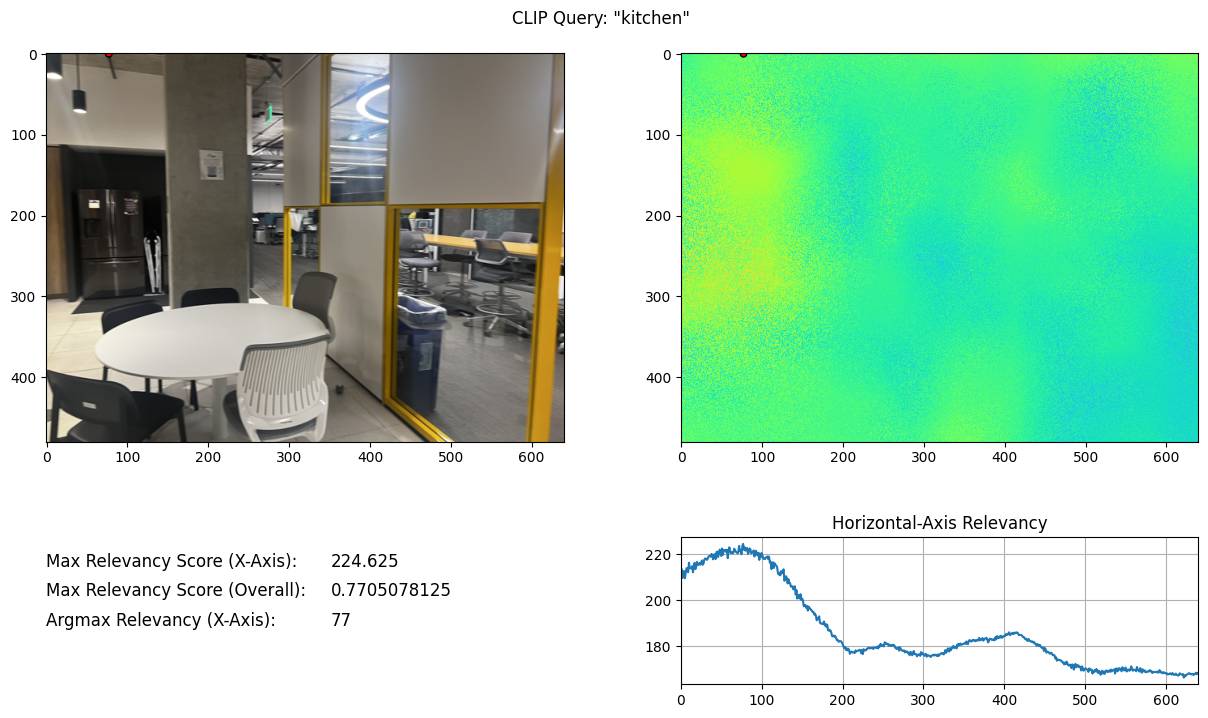

In [10]:
im_frame2 = Image.open('test_imgs/BWWK/IMG_6422.jpeg')
im_frame2 = im_frame2.resize((640, 480))
np_frame2 = np.array(im_frame2)
plot_clip_relevancy(torch.from_numpy(np_frame2).cuda(), "kitchen")

In [11]:
from PIL import Image
im_frame1 = Image.open('test_imgs/BWWK/IMG_6404.jpeg')
im_frame1 = im_frame1.resize((640, 480))
np_frame1 = np.array(im_frame1)

im_frame2 = Image.open('test_imgs/BlueSponge.jpeg')
im_frame2 = im_frame2.resize((640, 480))
np_frame2 = np.array(im_frame2)

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Using cache found in /home/yujustin/.cache/torch/hub/facebookresearch_dinov2_main
/home/yujustin/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/home/yujustin/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/home/yujustin/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


462
DinoEmbeddingProcess took 0.007433414459228516 seconds


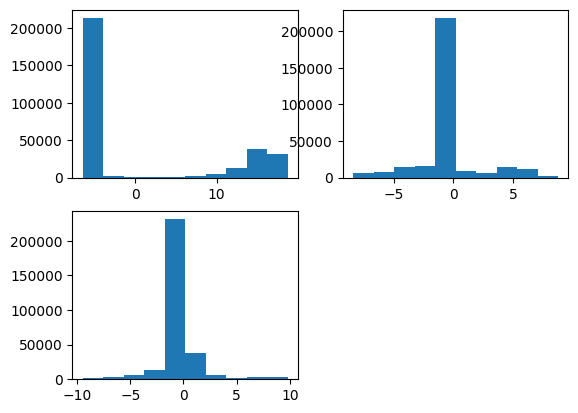

In [12]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

tt_frame2 = torch.from_numpy(np_frame2)

dino_frame_query = tt2dino(tt_frame2)
# print(dino_frame_query.shape)

# First PCA to Seperate Background
# sklearn expects 2d array for traning
total_features = dino_frame_query.reshape(640 * 480, 384) #H*W, 462)

pca = PCA(n_components=3)
pca.fit(total_features.cpu())
pca_features = pca.transform(total_features.cpu())

# visualize PCA components for finding a proper threshold
# 3 histograms for 3 components
plt.subplot(2, 2, 1)
plt.hist(pca_features[:, 0])
plt.subplot(2, 2, 2)
plt.hist(pca_features[:, 1])
plt.subplot(2, 2, 3)
plt.hist(pca_features[:, 2])
plt.show()
plt.close()

(307200, 3)


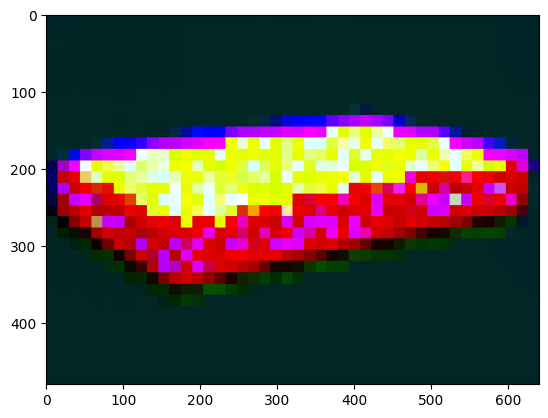

In [13]:
# min_max scale
pca_features[:, 0] = (pca_features[:, 0] - pca_features[:, 0].min()) / \
                     (pca_features[:, 0].max() - pca_features[:, 0].min())
#pca_features = sklearn.processing.minmax_scale(pca_features)

print(pca_features.shape)
plt.imshow(pca_features.reshape(tt_frame2.shape[0], tt_frame2.shape[1], 3))     

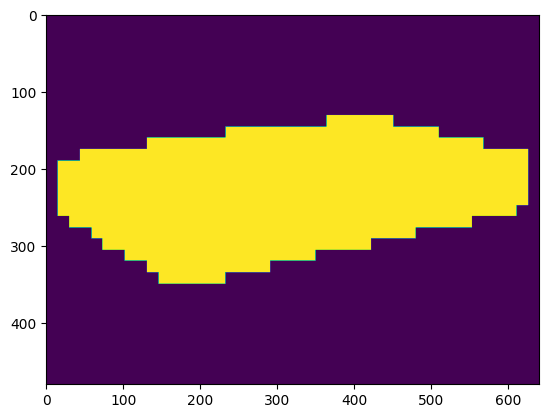

In [14]:
pca_features_bg = pca_features[:, 0] < 0.35
pca_features_fg = ~pca_features_bg

# plot the pca_features_bg

plt.imshow(pca_features_fg.reshape(tt_frame2.shape[0], tt_frame2.shape[1]))
plt.show()

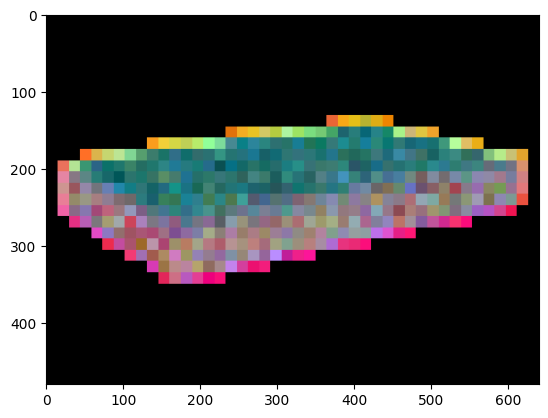

In [15]:
# 2nd PCA for only foreground patches
pca.fit(total_features[pca_features_fg].cpu()) 
pca_features_left = pca.transform(total_features[pca_features_fg].cpu())

for i in range(3):
    # min_max scaling
    pca_features_left[:, i] = (pca_features_left[:, i] - pca_features_left[:, i].min()) / (pca_features_left[:, i].max() - pca_features_left[:, i].min())

pca_features_rgb = pca_features.copy()
# for black background
pca_features_rgb[pca_features_bg] = 0
# new scaled foreground features
pca_features_rgb[pca_features_fg] = pca_features_left

# reshaping to numpy image format
pca_features_rgb = pca_features_rgb.reshape(tt_frame2.shape[0], tt_frame2.shape[1], 3)

plt.imshow(pca_features_rgb)

plt.show()

Scales: 100%|██████████| 7/7 [00:00<00:00, 9163.59it/s]


here 38 32 19
here 72 36 36
here 105 52 52
here 139 69 69
here 172 86 86
here 206 103 103
here 240 120 120


Scales:   0%|          | 0/7 [00:00<?, ?it/s]/home/yujustin/.local/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
Scales: 100%|██████████| 7/7 [00:00<00:00, 15.62it/s]


PyramidEmbeddingProcess took 0.4489719867706299 seconds


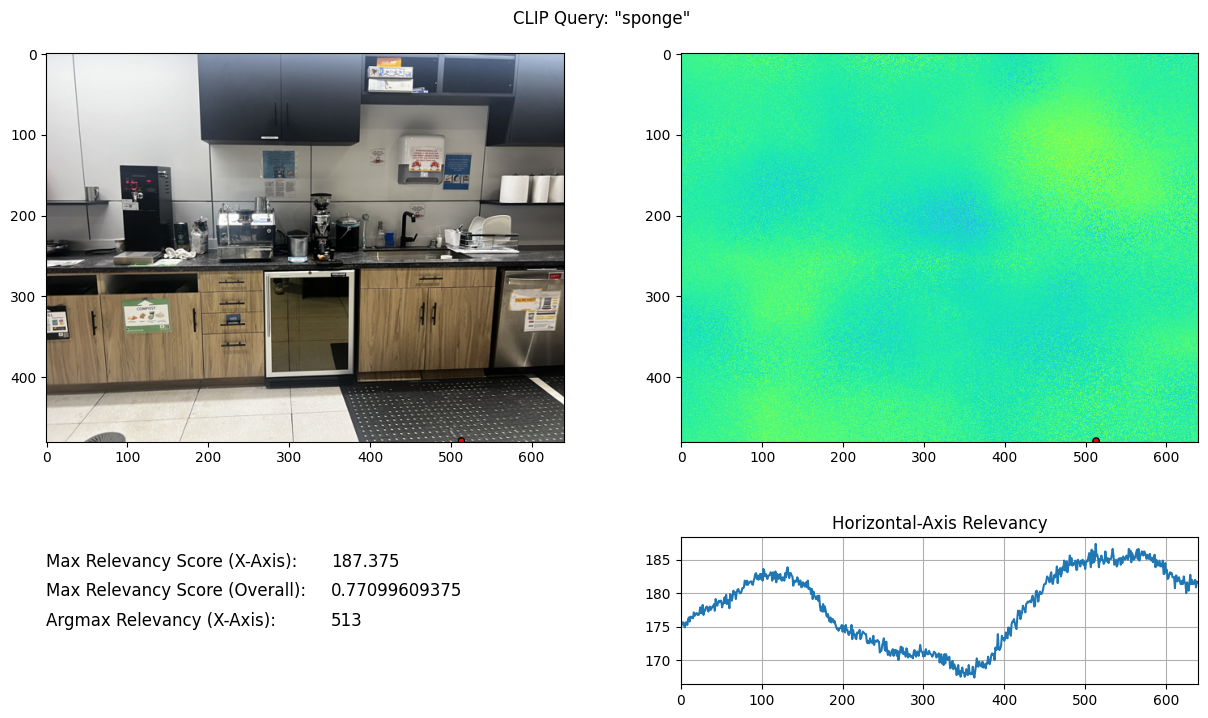

In [16]:
plot_clip_relevancy(torch.from_numpy(np_frame1).cuda(), 'sponge')

Using cache found in /home/yujustin/.cache/torch/hub/facebookresearch_dinov2_main


462
DinoEmbeddingProcess took 0.003239154815673828 seconds


Using cache found in /home/yujustin/.cache/torch/hub/facebookresearch_dinov2_main


462
DinoEmbeddingProcess took 0.0035028457641601562 seconds
torch.Size([216799, 384])
torch.Size([1])
torch.Size([307200])
tensor(279942, device='cuda:0')


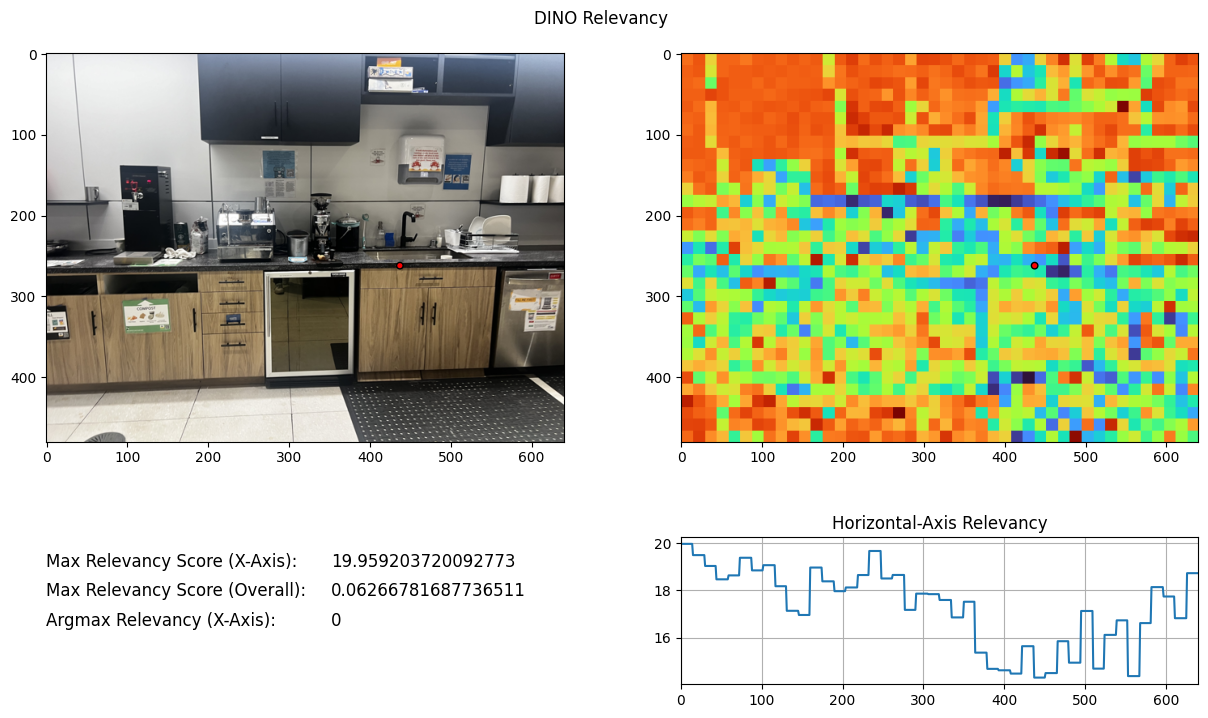

In [17]:
plot_dino_relevancy(torch.from_numpy(np_frame1).cuda(), torch.from_numpy(np_frame2).cuda(), pca_features_bg)

Scales: 100%|██████████| 7/7 [00:00<00:00, 9209.58it/s]


here 38 32 19
here 72 36 36
here 105 52 52
here 139 69 69
here 172 86 86
here 206 103 103
here 240 120 120


Scales: 100%|██████████| 7/7 [00:00<00:00, 15.73it/s]


PyramidEmbeddingProcess took 0.44570064544677734 seconds


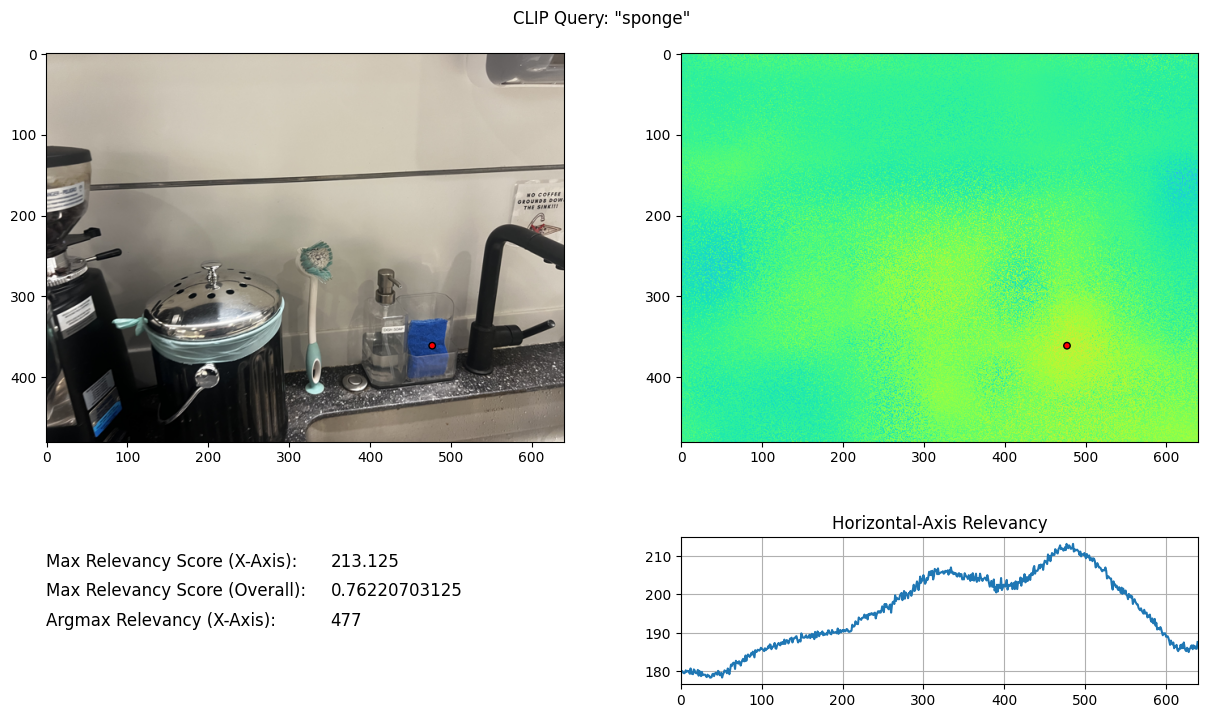

In [18]:
im_frame1 = Image.open('test_imgs/BWWK/IMG_6408.jpeg')
im_frame1 = im_frame1.resize((640, 480))
np_frame1 = np.array(im_frame1)
plot_clip_relevancy(torch.from_numpy(np_frame1).cuda(), "sponge")

Using cache found in /home/yujustin/.cache/torch/hub/facebookresearch_dinov2_main


462
DinoEmbeddingProcess took 0.003272533416748047 seconds


Using cache found in /home/yujustin/.cache/torch/hub/facebookresearch_dinov2_main


462
DinoEmbeddingProcess took 0.0030448436737060547 seconds
torch.Size([216799, 384])
torch.Size([1])
torch.Size([307200])
tensor(288640, device='cuda:0')


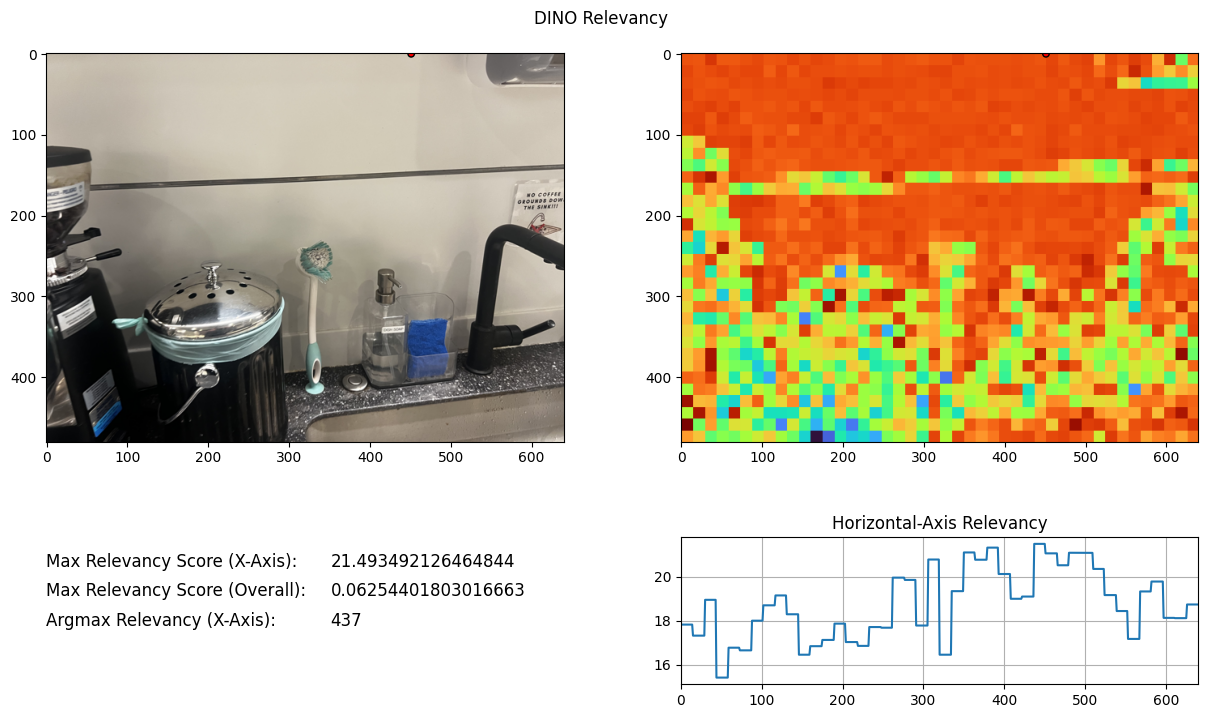

In [19]:
plot_dino_relevancy(torch.from_numpy(np_frame1).cuda(), torch.from_numpy(np_frame2).cuda(), pca_features_bg)

In [20]:
import PIL.Image as Image
import numpy as np
from sms.data.utils.detic_dataloader import DeticDataloader

im_frame1 = Image.open('/home/yujustin/Desktop/sms/sms/scripts/test_imgs/BWWK/IMG_6408.jpeg')
im_frame1 = im_frame1.resize((640, 480))
np_frame1 = np.array(im_frame1)

detic = DeticDataloader()
detic.create()
detic.default_vocab()


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


/home/yujustin/.local/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[06/18 18:14:34 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detic/Detic_LCOCOI21k_CLIP_SwinB_896b32_4x_ft4x_max-size.pth ...
SAM + Detic on device:  cuda
Loading pretrained CLIP
Resetting zs_weight datasets/metadata/lvis_v1_clip_a+cname.npy


In [21]:
out = detic.predict(np_frame1)

In [22]:
import PIL.Image as Image
import numpy as np
from sms.data.utils.detic_dataloader import DeticDataloader

im_frame1 = Image.open('/home/yujustin/Desktop/sms/sms/scripts/test_imgs/BWWK/IMG_6408.jpeg')
im_frame1 = im_frame1.resize((640, 480))
np_frame1 = np.array(im_frame1)

detic = DeticDataloader()
detic.create()
detic.default_vocab()
out = detic.predict(np_frame1)


[06/18 18:14:43 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detic/Detic_LCOCOI21k_CLIP_SwinB_896b32_4x_ft4x_max-size.pth ...
SAM + Detic on device:  cuda
Loading pretrained CLIP
Resetting zs_weight datasets/metadata/lvis_v1_clip_a+cname.npy


In [23]:
import matplotlib.pyplot as plt 
output_im = out[0].get_image()
print(output_im.shape)
plt.imshow(output_im)

KeyError: 0

: 